In [32]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy.stats import f_oneway
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
import re
import numpy as np
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

In [66]:
data=pd.read_excel('dades_27_08_2024.xlsx')
print(data.isna().sum())
print(f'{(data.isna().any(axis=1).sum()/data.shape[0])*100:.2f}% of rows have at least one Na value')

Referència                      0
Cost                            0
Exitus                          0
Especialitat d'acte mèdic       0
Risc                            0
Àrea assistencial               0
Tipus de praxi                128
Centre docent                   0
Tipologia d'acte mèdic        252
Àmbit                          55
Consentiment informat           0
País de naixement             491
Província de naixement        746
País llicenciatura             89
Especialitat                  529
Centre                         51
Codi nivell                  2423
Codi diagnòstic               666
Codi procediment mèdic        819
Seqüeles                        0
Reclamants                      0
Pacients                        0
Edat pacient                 2340
Reclamants_Exitus               0
Category                        0
dtype: int64
97.13% of rows have at least one Na value


In [67]:
df_filtered=data[data['Risc']=='Sí']
print(df_filtered.isna().sum())
print(f'{(df_filtered.isna().any(axis=1).sum()/df_filtered.shape[0])*100:.2f}% of rows have at least one Na value')

Referència                      0
Cost                            0
Exitus                          0
Especialitat d'acte mèdic       0
Risc                            0
Àrea assistencial               0
Tipus de praxi                 42
Centre docent                   0
Tipologia d'acte mèdic         93
Àmbit                          20
Consentiment informat           0
País de naixement             150
Província de naixement        250
País llicenciatura             25
Especialitat                  199
Centre                         18
Codi nivell                  1030
Codi diagnòstic               264
Codi procediment mèdic        315
Seqüeles                        0
Reclamants                      0
Pacients                        0
Edat pacient                  761
Reclamants_Exitus               0
Category                        0
dtype: int64
96.11% of rows have at least one Na value


In [68]:
#Mapping yes and no to 1 and 0 in binary features
df_filtered['Consentiment informat'] = df_filtered['Consentiment informat'].map({'No': 0, 'Sí': 1})
data['Consentiment informat'] = data['Consentiment informat'].map({'No': 0, 'Sí': 1})


#Dropping Cost feature to avoid information leakage
df_filtered.drop(columns=['Cost','Risc'], inplace=True)
data.drop(columns=['Cost'], inplace=True)


C:\Users\momoc\AppData\Local\Temp\ipykernel_24476\2121446518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Consentiment informat'] = df_filtered['Consentiment informat'].map({'No': 0, 'Sí': 1})
C:\Users\momoc\AppData\Local\Temp\ipykernel_24476\2121446518.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(columns=['Cost','Risc'], inplace=True)


In [69]:
# Check correlation and p-value of each numeric column to 'Category'
from scipy.stats import pearsonr

if 'Category' in data.columns:
    numeric_cols = data.select_dtypes(include='number').columns
    results = []
    for col in numeric_cols:
        if col != 'Category':
            valid = data[[col, 'Category']].dropna()
            if len(valid) > 1:
                corr, pval = pearsonr(valid[col], valid['Category'])
                results.append((col, corr, pval))
    print('Data correlations')
    print(f"{'Column':<20} {'Correlation':>12} {'P-value':>12}")
    for col, corr, pval in results:
        print(f"{col:<20} {corr:>12.4f} {pval:>12.4g}")
else:
    print("'Category' column not found in the dataset.")

#Columns Exitus, Consedntiment informat, Centre, Reclamants, and Reclamants_exitus are significantly correlated to Catgegory


Data correlations
Column                Correlation      P-value
Exitus                     0.0065       0.7083
Especialitat d'acte mèdic      -0.0066       0.7032
Àrea assistencial          0.0335      0.05362
Consentiment informat       0.0348      0.04528
Centre                    -0.0566     0.001217
Seqüeles                   0.0138       0.4279
Reclamants                 0.2101    2.495e-34
Pacients                   0.0590    0.0006818
Edat pacient               0.0773      0.01611
Reclamants_Exitus          0.0533     0.002179


In [70]:
# Check correlation and p-value of each numeric column to 'Category'
from scipy.stats import pearsonr

if 'Category' in df_filtered.columns:
    numeric_cols = df_filtered.select_dtypes(include='number').columns
    results = []
    for col in numeric_cols:
        if col != 'Category':
            valid = df_filtered[[col, 'Category']].dropna()
            if len(valid) > 1:
                corr, pval = pearsonr(valid[col], valid['Category'])
                results.append((col, corr, pval))
    print('Data Filtered correlations')
    print(f"{'Column':<20} {'Correlation':>12} {'P-value':>12}")
    for col, corr, pval in results:
        print(f"{col:<20} {corr:>12.4f} {pval:>12.4g}")
else:
    print("'Category' column not found in the dataset.")

#Columns Exitus, Consedntiment informat, Centre, Reclamants, and Reclamants_exitus are significantly correlated to Catgegory


Data Filtered correlations
Column                Correlation      P-value
Exitus                     0.1592    6.847e-09
Especialitat d'acte mèdic       0.0455      0.09983
Àrea assistencial          0.0475      0.08583
Consentiment informat      -0.0952     0.000558
Centre                    -0.1172    2.379e-05
Seqüeles                  -0.0122       0.6591
Reclamants                 0.2505    3.284e-20
Pacients                   0.0638      0.02091
Edat pacient               0.0369       0.3881
Reclamants_Exitus          0.1644    2.114e-09


In [71]:
# Check correlation between categorical columns and 'Category' using ANOVA F-test

cat_cols = data.select_dtypes(include=['object', 'category']).columns
anova_results = []
for col in cat_cols:
    if col != 'Category':
        groups = [group['Category'].dropna() for name, group in data.groupby(col)]
        if len(groups) > 1:
            f_stat, p_val = f_oneway(*groups)
            anova_results.append((col, f_stat, p_val))

print(f"{'Column':<30} {'F-statistic':>12} {'P-value':>12}")
for col, f_stat, p_val in anova_results:
    print(f"{col:<30} {f_stat:>12.4f} {p_val:>12.4g}")

#Columns Tipus de praxi, Tipologia d'acte medic, Ambit, Especialitat, Codi diagnostic and codi procediment medic are significantly correlated to Category

c:\Users\momoc\OneDrive\Desktop\AI\myenv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


Column                          F-statistic      P-value
Referència                              inf            0
Risc                               687.9321   6.435e-138
Tipus de praxi                      10.2238     3.75e-05
Centre docent                        0.2611       0.6094
Tipologia d'acte mèdic               1.6406      0.02165
Àmbit                                3.0332       0.0483
País de naixement                    0.7097       0.9251
Província de naixement               0.9382       0.6288
País llicenciatura                   0.7962       0.7513
Especialitat                         3.2117    4.113e-11
Codi nivell                          0.5699       0.7232
Codi diagnòstic                      1.2417    4.348e-05
Codi procediment mèdic               1.1716      0.00564


In [72]:
# Check correlation between categorical columns and 'Category' using ANOVA F-test

cat_cols = df_filtered.select_dtypes(include=['object', 'category']).columns
anova_results = []
for col in cat_cols:
    if col != 'Category':
        groups = [group['Category'].dropna() for name, group in df_filtered.groupby(col)]
        if len(groups) > 1:
            f_stat, p_val = f_oneway(*groups)
            anova_results.append((col, f_stat, p_val))

print(f"{'Column':<30} {'F-statistic':>12} {'P-value':>12}")
for col, f_stat, p_val in anova_results:
    print(f"{col:<30} {f_stat:>12.4f} {p_val:>12.4g}")

#Columns Tipus de praxi, Tipologia d'acte medic, Ambit, Especialitat, Codi diagnostic and codi procediment medic are significantly correlated to Category

c:\Users\momoc\OneDrive\Desktop\AI\myenv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


Column                          F-statistic      P-value
Referència                              inf            0
Tipus de praxi                       9.5785    7.434e-05
Centre docent                        0.3854       0.5348
Tipologia d'acte mèdic               2.6300     0.000166
Àmbit                                7.6245    0.0005107
País de naixement                    0.9481       0.5433
Província de naixement               0.9982       0.4814
País llicenciatura                   0.8816       0.6017
Especialitat                         3.7806    2.593e-12
Codi nivell                          1.3106       0.2596
Codi diagnòstic                      1.7036    1.705e-09
Codi procediment mèdic               1.4309    3.644e-05


In [73]:
#What to do with columns with NAs:
#Drop columns with NAs that have low statistical correlation with cost (Pais de naixement, Província de naixement, Paìs de llicentiatura, Codi nivell, Edad pacient, Referència, and Tipologia d'acte mèdic) in data
cols_to_drop = ['País de naixement', 'Província de naixement', 'País llicenciatura', 'Codi nivell', 'Edat pacient',"Tipologia d'acte mèdic",'Referència']
data.drop(columns=cols_to_drop, inplace=True, errors='ignore')

#Drop columns with NAs that have low statistical correlation with cost (Pais de naixement, Província de naixement, Paìs de llicentiatura, Codi nivell, Edad pacient, Referència) in data filtered by risk
cols_to_drop_filtered = ['País de naixement', 'Província de naixement', 'País llicenciatura', 'Codi nivell', 'Edat pacient','Referència']
df_filtered.drop(columns=cols_to_drop_filtered, inplace=True, errors='ignore')

C:\Users\momoc\AppData\Local\Temp\ipykernel_24476\1217693684.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(columns=cols_to_drop_filtered, inplace=True, errors='ignore')


In [74]:
#Check Nas again
print('data NAs')
print(f'{(data.isna().any(axis=1).sum()/data.shape[0])*100:.2f}% of rows have at least one Na value')

print('data filtered NAs')
print(f'{(df_filtered.isna().any(axis=1).sum()/df_filtered.shape[0])*100:.2f}% of rows have at least one Na value')

#Dropping all rows with NAs

data.dropna(inplace=True)
print(f'After dropping NAs, {data.shape[0]} rows remain in the original dataset.')

df_filtered.dropna(inplace=True)
print(f'After dropping NAs, {df_filtered.shape[0]} rows remain in the filtereddataset.')

data NAs
36.62% of rows have at least one Na value
data filtered NAs
37.53% of rows have at least one Na value
After dropping NAs, 2098 rows remain in the original dataset.
After dropping NAs, 819 rows remain in the filtereddataset.


C:\Users\momoc\AppData\Local\Temp\ipykernel_24476\2843644915.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(inplace=True)


In [75]:
duplicates = data.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')

# Display duplicate rows
duplicates_df = data[data.duplicated(keep=False)]
display(duplicates_df)

# Drop duplicate rows from the dataset
data.drop_duplicates(inplace=True)
print('Duplicate rows have been removed.')

#Removing - within the Codi procediment mèdic column
data = data[~data['Codi procediment mèdic'].astype(str).str.contains('-')]
data = data.reset_index(drop=True)

Number of duplicate rows: 11


,Exitus,Especialitat d'acte mèdic,Risc,Àrea assistencial,Tipus de praxi,Centre docent,Àmbit,Consentiment informat,Especialitat,Centre,Codi diagnòstic,Codi procediment mèdic,Seqüeles,Reclamants,Pacients,Reclamants_Exitus,Category
207,0,13,Sí,35,AMB CIRURGIA,No,PRIVAT,0,"CIRURGIA PLÀSTICA, ESTÈTICA I REPARADORA",11977.0,H02,08.3,86,0,1,0,1
424,0,13,No,35,AMB CIRURGIA,No,PRIVAT,0,"CIRURGIA PLÀSTICA, ESTÈTICA I REPARADORA",11977.0,E881,86.83,86,1,1,0,0
483,0,13,No,35,AMB CIRURGIA,No,PRIVAT,0,"CIRURGIA PLÀSTICA, ESTÈTICA I REPARADORA",11977.0,N642,85.54,86,0,1,0,0
951,0,13,Sí,35,AMB CIRURGIA,No,PRIVAT,0,"CIRURGIA PLÀSTICA, ESTÈTICA I REPARADORA",11977.0,H02,08.3,86,0,1,0,1
1006,0,13,No,35,AMB CIRURGIA,No,PRIVAT,1,"CIRURGIA PLÀSTICA, ESTÈTICA I REPARADORA",12065.0,Z411,86.83,86,1,1,0,0
1181,0,13,No,35,AMB CIRURGIA,No,PRIVAT,0,"CIRURGIA PLÀSTICA, ESTÈTICA I REPARADORA",11977.0,N642,85.54,86,0,1,0,0
1812,0,13,No,35,AMB CIRURGIA,No,PRIVAT,0,"CIRURGIA PLÀSTICA, ESTÈTICA I REPARADORA",11977.0,E881,86.83,86,1,1,0,0
2158,0,5,Sí,3,AMB CIRURGIA,No,PRIVAT,0,APARELL DIGESTIU,11977.0,Y640,99.29,153,5,5,0,2
2159,0,5,Sí,3,AMB CIRURGIA,No,PRIVAT,0,APARELL DIGESTIU,11977.0,Y640,99.29,153,5,5,0,2
2160,0,5,Sí,3,AMB CIRURGIA,No,PRIVAT,0,APARELL DIGESTIU,11977.0,Y640,99.29,153,5,5,0,2


Duplicate rows have been removed.


In [76]:
#Check for duplicate rows
duplicates_filtered = df_filtered.duplicated().sum()
print(f'Number of duplicate rows: {duplicates_filtered}')

# Display duplicate rows
duplicates_df_filtered = df_filtered[df_filtered.duplicated(keep=False)]
display(duplicates_df_filtered)

# Drop duplicate rows from the dataset
df_filtered.drop_duplicates(inplace=True)
print('Duplicate rows have been removed.')

#Removing - within the Codi procediment mèdic column
df_filtered = df_filtered[~df_filtered['Codi procediment mèdic'].astype(str).str.contains('-')]
df_filtered = df_filtered.reset_index(drop=True)

Number of duplicate rows: 7


,Exitus,Especialitat d'acte mèdic,Àrea assistencial,Tipus de praxi,Centre docent,Tipologia d'acte mèdic,Àmbit,Consentiment informat,Especialitat,Centre,Codi diagnòstic,Codi procediment mèdic,Seqüeles,Reclamants,Pacients,Reclamants_Exitus,Category
207,0,13,35,AMB CIRURGIA,No,PROGRAMAT,PRIVAT,0,"CIRURGIA PLÀSTICA, ESTÈTICA I REPARADORA",11977.0,H02,08.3,86,0,1,0,1
951,0,13,35,AMB CIRURGIA,No,PROGRAMAT,PRIVAT,0,"CIRURGIA PLÀSTICA, ESTÈTICA I REPARADORA",11977.0,H02,08.3,86,0,1,0,1
2158,0,5,3,AMB CIRURGIA,No,PROGRAMAT,PRIVAT,0,APARELL DIGESTIU,11977.0,Y640,99.29,153,5,5,0,2
2159,0,5,3,AMB CIRURGIA,No,PROGRAMAT,PRIVAT,0,APARELL DIGESTIU,11977.0,Y640,99.29,153,5,5,0,2
2160,0,5,3,AMB CIRURGIA,No,PROGRAMAT,PRIVAT,0,APARELL DIGESTIU,11977.0,Y640,99.29,153,5,5,0,2
2161,0,5,3,AMB CIRURGIA,No,PROGRAMAT,PRIVAT,0,APARELL DIGESTIU,11977.0,Y640,99.29,153,5,5,0,2
2162,0,5,3,AMB CIRURGIA,No,PROGRAMAT,PRIVAT,0,APARELL DIGESTIU,11977.0,Y640,99.29,153,5,5,0,2
2247,0,34,38,AMB CIRURGIA,No,PART,PRIVAT,0,OBSTETRICIA I GINECOLOGIA,12004.0,O701,72.6,107,2,2,0,1
2248,0,34,38,AMB CIRURGIA,No,PART,PRIVAT,0,OBSTETRICIA I GINECOLOGIA,12004.0,O701,72.6,107,2,2,0,1
2350,1,34,38,AMB CIRURGIA,No,PROGRAMAT,PRIVAT,0,OBSTETRICIA I GINECOLOGIA,12005.0,O640,74,58,2,2,2,2


Duplicate rows have been removed.


In [ ]:

#Startinng the pre-processing for the model
X=data.drop(columns=['Category'])
print(X.shape)
y=data['Category']

#Testing for oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42,sampling_strategy='minority')
X_resampled, y_resampled = ros.fit_resample(X, y)

X['Codi procediment mèdic']=X['Codi procediment mèdic'].astype('float').astype('int')
X_resampled['Codi procediment mèdic']=X_resampled['Codi procediment mèdic'].astype('float').astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print(X.columns)

#Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
#categorical_cols.remove('Codi diagnòstic')  # Excluding 'Codi diagnòstic' from categorical columns to encode it through ordinal encoding
numerical_cols = X_train.select_dtypes(include=['number']).columns.tolist()



(2073, 16)
Index(['Exitus', 'Especialitat d'acte mèdic', 'Risc', 'Àrea assistencial',
       'Tipus de praxi', 'Centre docent', 'Àmbit', 'Consentiment informat',
       'Especialitat', 'Centre', 'Codi diagnòstic', 'Codi procediment mèdic',
       'Seqüeles', 'Reclamants', 'Pacients', 'Reclamants_Exitus'],
      dtype='object')


In [ ]:

#Startinng the pre-processing for the model
X_filtered=df_filtered.drop(columns=['Category'])
print(X_filtered.shape)
y_filtered=df_filtered['Category']

#Testing for oversampling
X_resampled_f, y_resampled_f = ros.fit_resample(X_filtered, y_filtered)

X_filtered['Codi procediment mèdic']=X_filtered['Codi procediment mèdic'].astype('float').astype('int')
X_resampled_f['Codi procediment mèdic']=X_resampled_f['Codi procediment mèdic'].astype('float').astype('int')

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)
X_train_resampled_f, X_test_resampled_f, y_train_resampled_f, y_test_resampled_f = train_test_split(X_resampled_f, y_resampled_f, test_size=0.2, random_state=42)

print(X_resampled_f.columns)

#Identify categorical and numerical columns
categorical_cols_filt = X_train_f.select_dtypes(include=['object', 'category']).columns.tolist()
#categorical_cols.remove('Codi diagnòstic')  # Excluding 'Codi diagnòstic' from categorical columns to encode it through ordinal encoding
numerical_cols_filt = X_train_f.select_dtypes(include=['number']).columns.tolist()



(812, 16)
Index(['Exitus', 'Especialitat d'acte mèdic', 'Àrea assistencial',
       'Tipus de praxi', 'Centre docent', 'Tipologia d'acte mèdic', 'Àmbit',
       'Consentiment informat', 'Especialitat', 'Centre', 'Codi diagnòstic',
       'Codi procediment mèdic', 'Seqüeles', 'Reclamants', 'Pacients',
       'Reclamants_Exitus'],
      dtype='object')


In [79]:
#Order of diagnostic codes through function
#def sort_diagnostic_codes(codes):
#    import re
#    def code_key(code):
#        match = re.match(r"([A-Za-z]+)([0-9]+)", code)
#        if match:
#            letter, number = match.groups()
#            return (letter, int(number))
#        else:
#            return (code, 0)
#    return sorted(codes, key=code_key)

#icd10_codes = sort_diagnostic_codes(X['Codi diagnòstic'].unique().tolist())

#Creating the encoding for categorical columns
#ordinal_pipe=Pipeline(steps=[
#   ('ordinal', OrdinalEncoder(categories=[icd10_codes]))
#])

ohe_pipe=Pipeline(steps=[
    ('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'))
])

numerical_pipe=Pipeline(steps=[
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', ohe_pipe, categorical_cols),
#        ('ordinal', ordinal_pipe, ['Codi diagnòstic']),
        ('numerical', numerical_pipe, numerical_cols)
    ],
    remainder='passthrough', verbose_feature_names_out=False
)

pipe=Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',DecisionTreeClassifier())
])

In [80]:
#Defining the models and hyperparameters for GridSearchCV
param_grid=[
    {'model':[DecisionTreeClassifier()],
     'model__max_depth': [5, 10, 20],
     'model__min_samples_split': [2, 5, 10],
     'model__min_samples_leaf': [1, 2, 4]},

    {'model':[RandomForestClassifier()],
     'model__n_estimators': [100, 200, 500],
     'model__max_depth': [10, 20, 30],
     'model__min_samples_split': [2, 5, 10],
     'model__min_samples_leaf': [1, 2, 4]},

    {'model':[XGBClassifier()],
     'model__n_estimators': [100, 200],
     'model__max_depth': [3, 6],
     'model__learning_rate': [0.05, 0.1]},
]

In [81]:
#Defining the scoreing metrics to evaluate the models

#Soft accuracy function
def soft_accuracy(y_true, y_pred):
    step = 0.20 #since we have 5 classes
    return np.mean([1 - step * abs(p - t) for p, t in zip(y_pred, y_true)])

soft_acc_scorer = make_scorer(soft_accuracy, greater_is_better=True)

#Asymetric soft accuracy function to penalize under-predictions more than over-predictions
def asymmetric_soft_accuracy(y_true, y_pred):
    step = 0.25
    under_penalty = 1.5  
    over_penalty = 1.0 
    accs = []
    for t, p in zip(y_true, y_pred):
        diff = p - t
        if diff < 0:
            penalty = under_penalty * abs(diff)
        else:
            penalty = over_penalty * diff
        accs.append(1 - step * penalty)
    return np.mean(accs)

asymmetric_scorer = make_scorer(asymmetric_soft_accuracy, greater_is_better=True)


In [86]:
grid_soft = GridSearchCV(pipe, param_grid, scoring=soft_acc_scorer, cv=5)
grid_asymmetric = GridSearchCV(pipe, param_grid, scoring=asymmetric_scorer, cv=5)

In [87]:
#Fitting the models on orginal data and non resampled - SOFT
grid_soft.fit(X_train, y_train)

# Save best result
best_model = grid_soft.best_estimator_
best_score = -grid_soft.best_score_ 

In [88]:
#Fitting the models on orginal data and non resampled - ASYMMETRIC
grid_asymmetric.fit(X_train, y_train)

# Save best result
best_model_as = grid_asymmetric.best_estimator_
best_score_as = grid_asymmetric.best_score_ 

In [89]:
#Fitting the models on orginal data and resampled - SOFT
grid_soft.fit(X_train_resampled, y_train_resampled)

# Save best result
best_model_res = grid_soft.best_estimator_
best_score_res = grid_soft.best_score_ 

In [90]:
#Fitting the models on orginal data and resampled - ASYMMETRIC
grid_asymmetric.fit(X_train_resampled, y_train_resampled)

# Save best result
best_model_res_as = grid_asymmetric.best_estimator_
best_score_res_as = grid_asymmetric.best_score_ 

In [92]:
#Order of diagnostic codes through function
#def sort_diagnostic_codes(codes):
#    import re
#    def code_key(code):
#        match = re.match(r"([A-Za-z]+)([0-9]+)", code)
#        if match:
#            letter, number = match.groups()
#            return (letter, int(number))
#        else:
#            return (code, 0)
#    return sorted(codes, key=code_key)

#icd10_codes = sort_diagnostic_codes(X['Codi diagnòstic'].unique().tolist())

#Creating the encoding for categorical columns
#ordinal_pipe=Pipeline(steps=[
#   ('ordinal', OrdinalEncoder(categories=[icd10_codes]))
#])

ohe_pipe=Pipeline(steps=[
    ('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'))
])

numerical_pipe=Pipeline(steps=[
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', ohe_pipe, categorical_cols_filt),
#        ('ordinal', ordinal_pipe, ['Codi diagnòstic']),
        ('numerical', numerical_pipe, numerical_cols_filt)
    ],
    remainder='passthrough', verbose_feature_names_out=False
)

pipe_filt=Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',DecisionTreeClassifier())
])
grid_soft_f = GridSearchCV(pipe_filt, param_grid, scoring=soft_acc_scorer, cv=5)
grid_asymmetric_f = GridSearchCV(pipe_filt, param_grid, scoring=asymmetric_scorer, cv=5)

In [93]:
#Fitting the models on filtered data and non resampled - SOFT
grid_soft_f.fit(X_train_f, y_train_f)

# Save best result
best_model_f = grid_soft_f.best_estimator_
best_score_f = grid_soft_f.best_score_ 

In [94]:
#Fitting the models on filtered data and non resampled - ASYMMETRIC
grid_asymmetric_f.fit(X_train_f, y_train_f)

# Save best result
best_model_f_as = grid_asymmetric_f.best_estimator_
best_score_f_as = grid_asymmetric_f.best_score_ 

In [95]:
#Fitting the models on filtered data and resampled - SOFT
grid_soft_f.fit(X_train_resampled_f, y_train_resampled_f)

# Save best result
best_model_res_f = grid_soft_f.best_estimator_
best_score_res_f = grid_soft_f.best_score_ 

In [96]:
#Fitting the models on filtered data and non resampled - ASYMMETRIC
grid_asymmetric_f.fit(X_train_resampled_f, y_train_resampled_f)

# Save best result
best_model_res_f_as = grid_asymmetric_f.best_estimator_
best_score_res_f_as = grid_asymmetric_f.best_score_ 

In [98]:
best_models_list= [best_model, best_model_as, best_model_res, best_model_res_as, best_model_f, best_model_f_as, best_model_res_f, best_model_res_f_as]
best_scores_list = [best_score, best_score_as, best_score_res, best_score_res_as, best_score_f, best_score_f_as, best_score_res_f, best_score_res_f_as] 

c:\Users\momoc\OneDrive\Desktop\AI\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Original data - Soft; Soft Accuracy: 0.9075, Asymmetric Accuracy: 0.8377, Accuracy: 0.7446, Precision: 0.6675, Recall: 0.7446, F1 Score: 0.6999


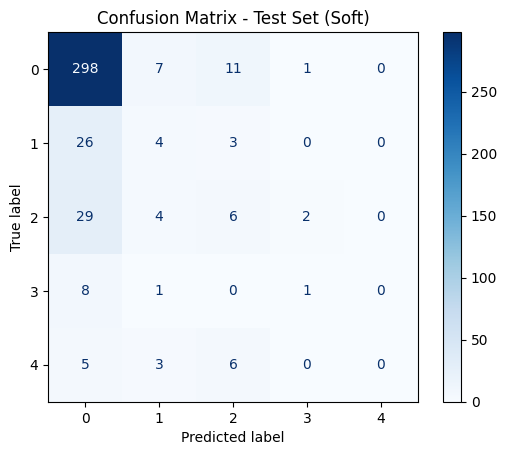

In [99]:
#Evaluating the best models on the test set for original data - SOFT
y_pred = best_model.predict(X_test)

soft_acc =soft_accuracy(y_test, y_pred)
asymmetric_acc =asymmetric_soft_accuracy(y_test, y_pred)
accuracy=accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred, average='weighted')
recall=recall_score(y_test, y_pred, average='weighted')
f1=f1_score(y_test, y_pred, average='weighted')

print(f'Original data - Soft; Soft Accuracy: {soft_acc:.4f}, Asymmetric Accuracy: {asymmetric_acc:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set (Soft)')
plt.show()

Original data - Asymmetric; Soft Accuracy: 0.9075, Asymmetric Accuracy: 0.8377, Accuracy: 0.7446, Precision: 0.6675, Recall: 0.7446, F1 Score: 0.6999


c:\Users\momoc\OneDrive\Desktop\AI\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


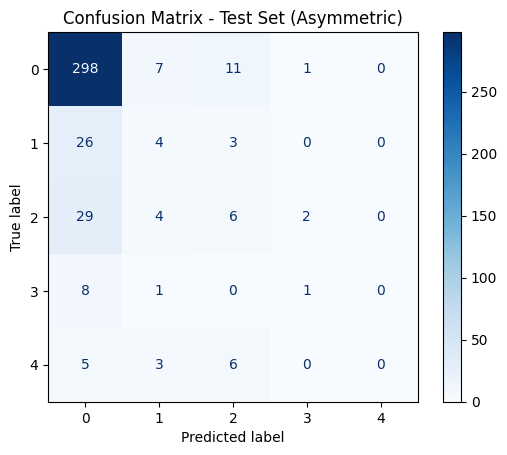

In [100]:
#Evaluating the best models on the test set for original data - ASYMMETRIC
y_pred_as = best_model_as.predict(X_test)

soft_acc_as = soft_accuracy(y_test, y_pred_as)
asymmetric_acc_as = asymmetric_soft_accuracy(y_test, y_pred_as)
accuracy_as = accuracy_score(y_test, y_pred_as)
precision_as = precision_score(y_test, y_pred_as, average='weighted')
recall_as = recall_score(y_test, y_pred_as, average='weighted')
f1_as = f1_score(y_test, y_pred_as, average='weighted')

print(f'Original data - Asymmetric; Soft Accuracy: {soft_acc_as:.4f}, Asymmetric Accuracy: {asymmetric_acc_as:.4f}, Accuracy: {accuracy_as:.4f}, Precision: {precision_as:.4f}, Recall: {recall_as:.4f}, F1 Score: {f1_as:.4f}')

cm_as = confusion_matrix(y_test, y_pred_as)
disp_as = ConfusionMatrixDisplay(confusion_matrix=cm_as)
disp_as.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set (Asymmetric)')
plt.show()

Resampled data - Soft; Soft Accuracy: 0.9469, Asymmetric Accuracy: 0.9047, Accuracy: 0.8489, Precision: 0.7974, Recall: 0.8489, F1 Score: 0.7931


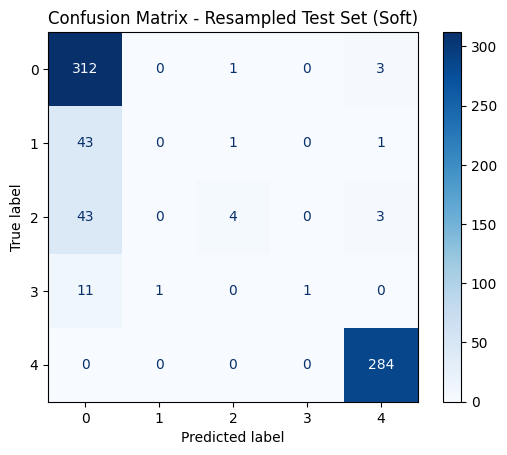

In [101]:
#Evaluating the best models on the test set for resampled data - SOFT
y_pred_res = best_model_res.predict(X_test_resampled)

soft_acc_res = soft_accuracy(y_test_resampled, y_pred_res)
asymmetric_acc_res = asymmetric_soft_accuracy(y_test_resampled, y_pred_res)
accuracy_res = accuracy_score(y_test_resampled, y_pred_res)
precision_res = precision_score(y_test_resampled, y_pred_res, average='weighted')
recall_res = recall_score(y_test_resampled, y_pred_res, average='weighted')
f1_res = f1_score(y_test_resampled, y_pred_res, average='weighted')

print(f'Resampled data - Soft; Soft Accuracy: {soft_acc_res:.4f}, Asymmetric Accuracy: {asymmetric_acc_res:.4f}, Accuracy: {accuracy_res:.4f}, Precision: {precision_res:.4f}, Recall: {recall_res:.4f}, F1 Score: {f1_res:.4f}')

cm_res = confusion_matrix(y_test_resampled, y_pred_res)
disp_res = ConfusionMatrixDisplay(confusion_matrix=cm_res)
disp_res.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Resampled Test Set (Soft)')
plt.show()

Resampled data - Asymmetric; Soft Accuracy: 0.9477, Asymmetric Accuracy: 0.9128, Accuracy: 0.8475, Precision: 0.8052, Recall: 0.8475, F1 Score: 0.8157


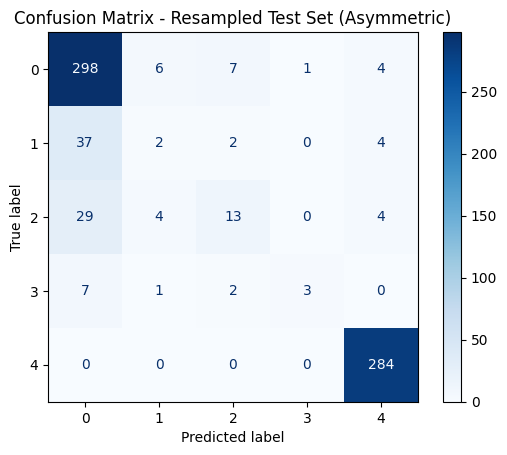

In [102]:
#Evaluating the best models on the test set for resampled data - ASYMMETRIC
y_pred_res_as = best_model_res_as.predict(X_test_resampled)

soft_acc_res_as = soft_accuracy(y_test_resampled, y_pred_res_as)
asymmetric_acc_res_as = asymmetric_soft_accuracy(y_test_resampled, y_pred_res_as)
accuracy_res_as = accuracy_score(y_test_resampled, y_pred_res_as)
precision_res_as = precision_score(y_test_resampled, y_pred_res_as, average='weighted')
recall_res_as = recall_score(y_test_resampled, y_pred_res_as, average='weighted')
f1_res_as = f1_score(y_test_resampled, y_pred_res_as, average='weighted')

print(f'Resampled data - Asymmetric; Soft Accuracy: {soft_acc_res_as:.4f}, Asymmetric Accuracy: {asymmetric_acc_res_as:.4f}, Accuracy: {accuracy_res_as:.4f}, Precision: {precision_res_as:.4f}, Recall: {recall_res_as:.4f}, F1 Score: {f1_res_as:.4f}')

cm_res_as = confusion_matrix(y_test_resampled, y_pred_res_as)
disp_res_as = ConfusionMatrixDisplay(confusion_matrix=cm_res_as)
disp_res_as.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Resampled Test Set (Asymmetric)')
plt.show()

Filtered data - Soft; Soft Accuracy: 0.8184, Asymmetric Accuracy: 0.6956,, Accuracy: 0.4540, Precision: 0.4270, Recall: 0.4540, F1 Score: 0.4207


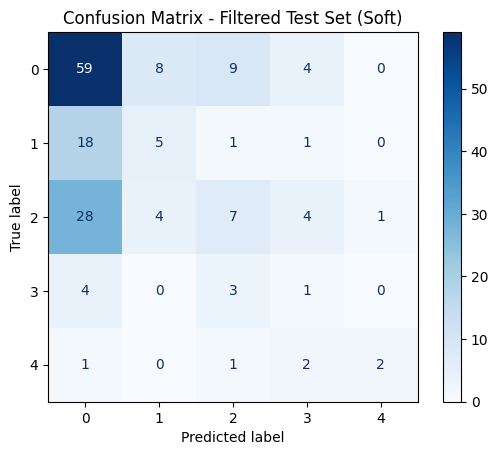

In [103]:
#Evaluating the best models on the test set for filtered data - SOFT
y_pred_f = best_model_f.predict(X_test_f)

soft_acc_f = soft_accuracy(y_test_f, y_pred_f)
asymmetric_acc_f = asymmetric_soft_accuracy(y_test_f, y_pred_f)
accuracy_f = accuracy_score(y_test_f, y_pred_f)
precision_f = precision_score(y_test_f, y_pred_f, average='weighted')
recall_f = recall_score(y_test_f, y_pred_f, average='weighted')
f1_f = f1_score(y_test_f, y_pred_f, average='weighted')

print(f'Filtered data - Soft; Soft Accuracy: {soft_acc_f:.4f}, Asymmetric Accuracy: {asymmetric_acc_f:.4f},, Accuracy: {accuracy_f:.4f}, Precision: {precision_f:.4f}, Recall: {recall_f:.4f}, F1 Score: {f1_f:.4f}')

cm_f = confusion_matrix(y_test_f, y_pred_f)
disp_f = ConfusionMatrixDisplay(confusion_matrix=cm_f)
disp_f.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Filtered Test Set (Soft)')
plt.show()

Filtered data - Asymmetric; Soft Accuracy: 0.8184, Asymmetric Accuracy: 0.6956, Accuracy: 0.4540, Precision: 0.4270, Recall: 0.4540, F1 Score: 0.4207


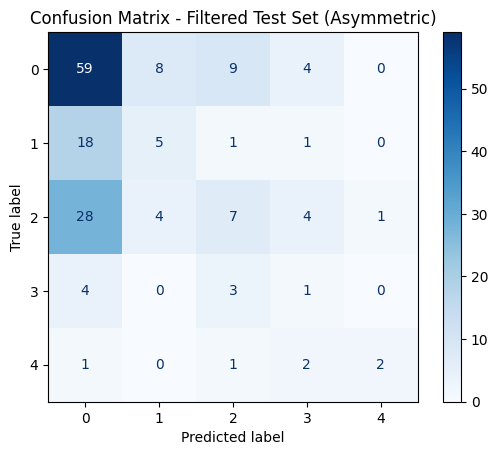

In [104]:
#Evaluating the best models on the test set for filtered data - ASYMMETRIC
y_pred_f_as = best_model_f_as.predict(X_test_f)

soft_acc_f_as = soft_accuracy(y_test_f, y_pred_f_as)
asymmetric_acc_f_as = asymmetric_soft_accuracy(y_test_f, y_pred_f_as)
accuracy_f_as = accuracy_score(y_test_f, y_pred_f_as)
precision_f_as = precision_score(y_test_f, y_pred_f_as, average='weighted')
recall_f_as = recall_score(y_test_f, y_pred_f_as, average='weighted')
f1_f_as = f1_score(y_test_f, y_pred_f_as, average='weighted')

print(f'Filtered data - Asymmetric; Soft Accuracy: {soft_acc_f_as:.4f}, Asymmetric Accuracy: {asymmetric_acc_f_as:.4f}, Accuracy: {accuracy_f_as:.4f}, Precision: {precision_f_as:.4f}, Recall: {recall_f_as:.4f}, F1 Score: {f1_f_as:.4f}')

cm_f_as = confusion_matrix(y_test_f, y_pred_f_as)
disp_f_as = ConfusionMatrixDisplay(confusion_matrix=cm_f_as)
disp_f_as.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Filtered Test Set (Asymmetric)')
plt.show()

Resampled filtered data - Soft; Soft Accuracy: 0.8828, Asymmetric Accuracy: 0.7963,Accuracy: 0.6293, Precision: 0.5614, Recall: 0.6293, F1 Score: 0.5751


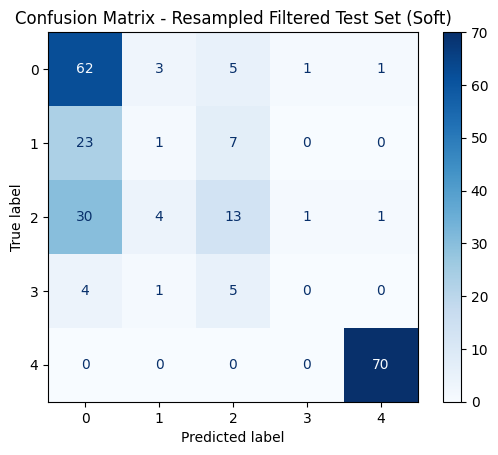

In [105]:
#Evaluating the best models on the test set for resampled filtered data - SOFT
y_pred_res_f = best_model_res_f.predict(X_test_resampled_f)

soft_acc_res_f = soft_accuracy(y_test_resampled_f, y_pred_res_f)
asymmetric_acc_res_f = asymmetric_soft_accuracy(y_test_resampled_f, y_pred_res_f)
accuracy_res_f = accuracy_score(y_test_resampled_f, y_pred_res_f)
precision_res_f = precision_score(y_test_resampled_f, y_pred_res_f, average='weighted')
recall_res_f = recall_score(y_test_resampled_f, y_pred_res_f, average='weighted')
f1_res_f = f1_score(y_test_resampled_f, y_pred_res_f, average='weighted')

print(f'Resampled filtered data - Soft; Soft Accuracy: {soft_acc_res_f:.4f}, Asymmetric Accuracy: {asymmetric_acc_res_f:.4f},Accuracy: {accuracy_res_f:.4f}, Precision: {precision_res_f:.4f}, Recall: {recall_res_f:.4f}, F1 Score: {f1_res_f:.4f}')

cm_res_f = confusion_matrix(y_test_resampled_f, y_pred_res_f)
disp_res_f = ConfusionMatrixDisplay(confusion_matrix=cm_res_f)
disp_res_f.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Resampled Filtered Test Set (Soft)')
plt.show()

Resampled filtered data - Asymmetric; Soft Accuracy: 0.8690, Asymmetric Accuracy: 0.7893, Accuracy: 0.6078, Precision: 0.5564, Recall: 0.6078, F1 Score: 0.5710


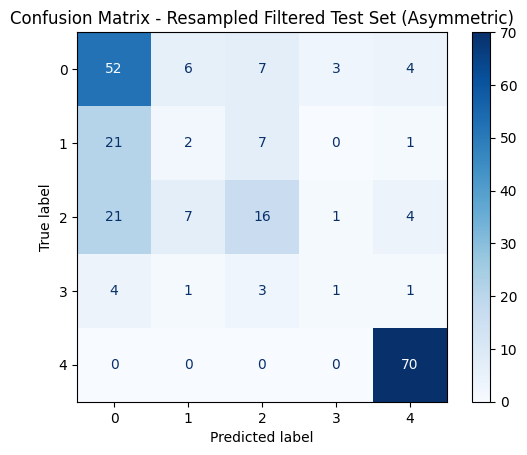

In [106]:
#Evaluating the best models on the test set for resampled filtered data - ASYMMETRIC
y_pred_res_f_as = best_model_res_f_as.predict(X_test_resampled_f)

soft_acc_res_f_as = soft_accuracy(y_test_resampled_f, y_pred_res_f_as)
asymmetric_acc_res_f_as = asymmetric_soft_accuracy(y_test_resampled_f, y_pred_res_f_as)
accuracy_res_f_as = accuracy_score(y_test_resampled_f, y_pred_res_f_as)
precision_res_f_as = precision_score(y_test_resampled_f, y_pred_res_f_as, average='weighted')
recall_res_f_as = recall_score(y_test_resampled_f, y_pred_res_f_as, average='weighted')
f1_res_f_as = f1_score(y_test_resampled_f, y_pred_res_f_as, average='weighted')

print(f'Resampled filtered data - Asymmetric; Soft Accuracy: {soft_acc_res_f_as:.4f}, Asymmetric Accuracy: {asymmetric_acc_res_f_as:.4f}, Accuracy: {accuracy_res_f_as:.4f}, Precision: {precision_res_f_as:.4f}, Recall: {recall_res_f_as:.4f}, F1 Score: {f1_res_f_as:.4f}')

cm_res_f_as = confusion_matrix(y_test_resampled_f, y_pred_res_f_as)
disp_res_f_as = ConfusionMatrixDisplay(confusion_matrix=cm_res_f_as)
disp_res_f_as.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Resampled Filtered Test Set (Asymmetric)')
plt.show()

In [ ]:
# Calculate and print the percentage of rows with category = 0
category_0_pct = (df_filtered['Category'] == 0).mean() * 100
print(f'Percentage of rows with Category = 0: {category_0_pct:.2f}%')

Percentage of rows with Category = 0: 45.79%


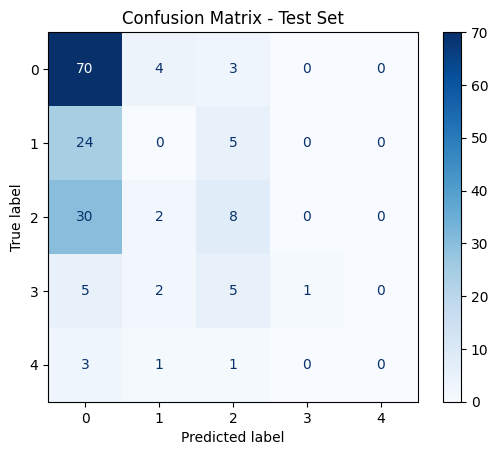

In [38]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.show()

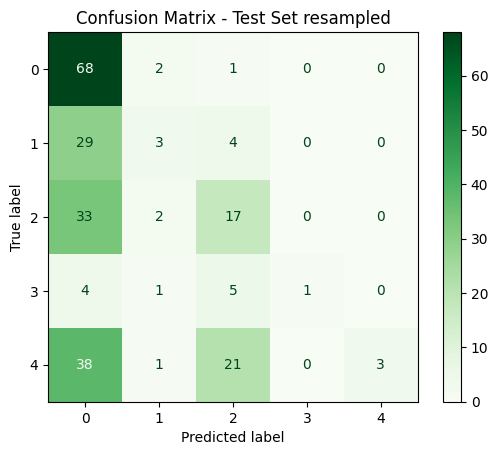

In [52]:
cm_resampled = confusion_matrix(y_test_resampled, y_pred_resampled)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_resampled)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix - Test Set resampled')
plt.show()